## Modelo 2

Se cargan las librerías.

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator

from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score
import seaborn as sns
import pickle
import yaml

Se cargan los datos procesados.

In [2]:
segmentos = []

# Leer los archivos CSV segmentados y almacenarlos en la lista
for i in range(0,3):
    segmento = pd.read_csv(f'../data/processed/segmento_{i+1}.csv')
    segmentos.append(segmento)
# Concatenar los DataFrames de los segmentos en uno solo
df1 = pd.concat(segmentos, ignore_index=True)

Se separa el test del Dataframe original no balanceado para asegurar que los datos nuevos serán similares a los reales a predecir, manteniendo proporción en los datos

In [3]:
# Crear las variables para features y target
X = df1[['amt', 'city_pop', 'distancia', 'fraudes_por_Categoria',
       'fraudes_por_estado', 'fraudes_por_edad', 'fraudes_por_hora',
       'fraudes_por_día']]
y = df1['is_fraud']

# Separamos una muestra del DataFrame para probar el modelo
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.1,
                                                   random_state=0, stratify=y)


Una vez obtenido el test, se pasa a balancear los datos, tanto para aligerar la carga del entrenamiento, como para intentar que el modelo prediga mejor la clase minoritaría.

In [11]:
# Aplicamos undersampling a los datos
rus = RandomUnderSampler()

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Separamos el nuevo conjunto en X e y
X_under = X_resampled
y_under = y_resampled

Se separa en train y test.

Con un GridSearch, se hiperparametriza un GradientBoostingClassifier.

In [53]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", GradientBoostingClassifier())
])

# Definir los parámetros del GridSearchCV
gb_params = {
    'selectkbest__k': np.arange(2, 8),
    'classifier__loss': ['log_loss', 'exponential'],
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'classifier__max_depth': np.arange(6, 9),
    'classifier__min_samples_leaf': np.arange(4, 7),
    'classifier__max_features': np.arange(6, 9),
}
# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=gb_params, cv=3, scoring="roc_auc")

# Ajustar el GridSearchCV
clf.fit(X_resampled, y_resampled)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             param_grid={'classifier__learning_rate': [0.1, 0.01, 0.001],
                         'classifier__loss': ['log_loss', 'exponential'],
                         'classifier__max_depth': array([6, 7, 8]),
                         'classifier__max_features': array([6, 7, 8]),
                         'classifier__min_samples_leaf': array([4, 5, 6]),
                         'selectkbest__k': array([2, 3, 4, 5, 6, 7])},
             scoring='roc_auc')

In [54]:
clf.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__loss': 'log_loss',
 'classifier__max_depth': 6,
 'classifier__max_features': 8,
 'classifier__min_samples_leaf': 6,
 'selectkbest__k': 3}

In [55]:
predictions = clf.predict(X_test)

[[125564   3353]
 [    24    727]]


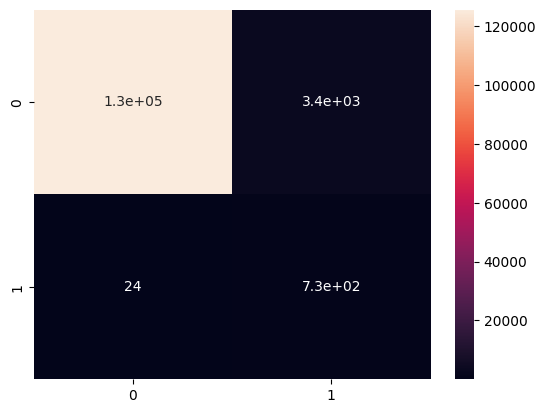

In [56]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [57]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

In [58]:
precision_score(y_test, predictions)

0.17818627450980393

In [59]:
recall_score(y_test, predictions)

0.9680426098535286

In [60]:
roc_auc_score(y_test, predictions)

0.9710168136649447

In [61]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", GradientBoostingClassifier())
])

# Definir los parámetros del GridSearchCV
gb_params = {
    'selectkbest__k': np.arange(5, 8),
    'classifier__loss': ['log_loss', 'exponential'],
    'classifier__learning_rate': [0.1, 0.01],
    'classifier__max_depth': np.arange(7,8),
    'classifier__min_samples_split': np.arange(4,5),
    'classifier__min_samples_leaf': np.arange(3, 6),
    'classifier__max_features': np.arange(4, 7),
}

# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=gb_params, cv=3, scoring="precision")

# Ajustar el GridSearchCV
clf.fit(X_resampled, y_resampled)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             param_grid={'classifier__learning_rate': [0.1, 0.01],
                         'classifier__loss': ['log_loss', 'exponential'],
                         'classifier__max_depth': array([7]),
                         'classifier__max_features': array([4, 5, 6]),
                         'classifier__min_samples_leaf': array([3, 4, 5]),
                         'classifier__min_samples_split': array([4]),
                         'selectkbest__k': array([5, 6, 7])},
             scoring='precision')

In [62]:
clf.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__loss': 'log_loss',
 'classifier__max_depth': 7,
 'classifier__max_features': 5,
 'classifier__min_samples_leaf': 3,
 'classifier__min_samples_split': 4,
 'selectkbest__k': 5}

In [63]:
predictions = clf.predict(X_test)

[[125470   3447]
 [    15    736]]


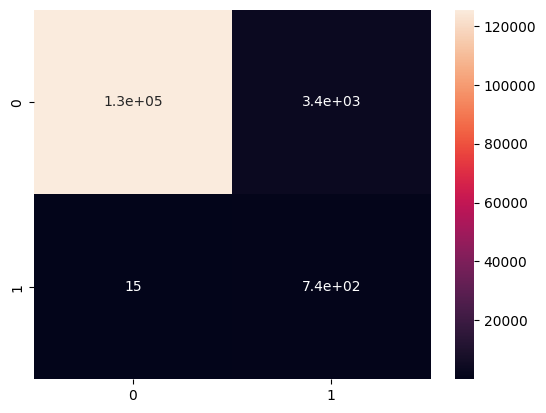

In [64]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [65]:
print("Precision score:", precision_score(y_test, predictions))
print("Recall score:", recall_score(y_test, predictions))
print("ROC AUC score:", roc_auc_score(y_test, predictions))

Precision score: 0.17595027492230456
Recall score: 0.9800266311584553
ROC AUC score: 0.9766442486602023


In [69]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", GradientBoostingClassifier())
])

gb_params = {
    'selectkbest__k': np.arange(5, 8),
    'classifier__loss': ['log_loss', 'exponential'],
    'classifier__learning_rate': [0.1, 0.01],
    'classifier__max_depth': np.arange(15, 20),
    'classifier__max_features': np.arange(4, 7),
}

# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=gb_params, cv=3, scoring="roc_auc")

# Ajustar el GridSearchCV
clf.fit(X_resampled, y_resampled)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             param_grid={'classifier__learning_rate': [0.1, 0.01],
                         'classifier__loss': ['log_loss', 'exponential'],
                         'classifier__max_depth': array([15, 16, 17, 18, 19]),
                         'classifier__max_features': array([4, 5, 6]),
                         'selectkbest__k': array([5, 6, 7])},
             scoring='roc_auc')

In [70]:
clf.best_params_

{'classifier__learning_rate': 0.01,
 'classifier__loss': 'exponential',
 'classifier__max_depth': 16,
 'classifier__max_features': 4,
 'selectkbest__k': 7}

In [71]:
predictions = clf.predict(X_test)

[[125655   3262]
 [    15    736]]


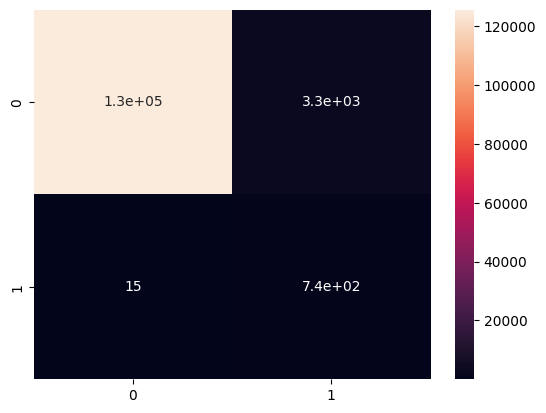

In [72]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [73]:
print("Precision score:", precision_score(y_test, predictions))
print("Recall score:", recall_score(y_test, predictions))
print("ROC AUC score:", roc_auc_score(y_test, predictions))

Precision score: 0.18409204602301152
Recall score: 0.9800266311584553
ROC AUC score: 0.9773617645812988


In [13]:
# Para escribir el archivo pickle
with open('../models/Model2/trained_model.pkl', 'wb') as archivo_salida:
    pickle.dump(clf.best_estimator_, archivo_salida)

# Para escribir el archivo YAML
with open("../models/Model2/model_config.yaml", "w") as f:
    yaml.dump(clf.best_params_, f)

De los modelos hiperparametrizados, este es el mejor, por tanto, se ha guardado en formato pickle.

In [4]:
# Definir el pipeline
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", GradientBoostingClassifier())
])

gb_params = {
    'selectkbest__k': [6],
    'classifier__loss': ['exponential'],
    'classifier__learning_rate': [0.01],
    'classifier__max_depth': [15],
}

# Crear el GridSearchCV
clf = GridSearchCV(estimator=pipe, param_grid=gb_params, cv=3, scoring="roc_auc", verbose=10)

# Ajustar el GridSearchCV
clf.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START classifier__learning_rate=0.01, classifier__loss=exponential, classifier__max_depth=15, selectkbest__k=6
[CV 1/3; 1/1] END classifier__learning_rate=0.01, classifier__loss=exponential, classifier__max_depth=15, selectkbest__k=6;, score=0.934 total time= 6.7min
[CV 2/3; 1/1] START classifier__learning_rate=0.01, classifier__loss=exponential, classifier__max_depth=15, selectkbest__k=6
[CV 2/3; 1/1] END classifier__learning_rate=0.01, classifier__loss=exponential, classifier__max_depth=15, selectkbest__k=6;, score=0.940 total time= 6.7min
[CV 3/3; 1/1] START classifier__learning_rate=0.01, classifier__loss=exponential, classifier__max_depth=15, selectkbest__k=6
[CV 3/3; 1/1] END classifier__learning_rate=0.01, classifier__loss=exponential, classifier__max_depth=15, selectkbest__k=6;, score=0.940 total time= 8.8min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             param_grid={'classifier__learning_rate': [0.01],
                         'classifier__loss': ['exponential'],
                         'classifier__max_depth': [15], 'selectkbest__k': [6]},
             scoring='roc_auc', verbose=10)

In [6]:
predictions = clf.predict(X_test)

In [7]:
clf.best_params_

{'classifier__learning_rate': 0.01,
 'classifier__loss': 'exponential',
 'classifier__max_depth': 15,
 'selectkbest__k': 6}

[[128917      0]
 [   751      0]]


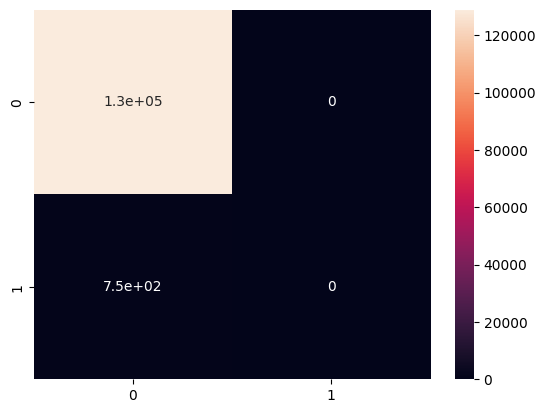

In [8]:
c_matrix = confusion_matrix(y_test, predictions)
print(c_matrix)
sns.heatmap(c_matrix, annot=True);

In [9]:
print("Precision score:", precision_score(y_test, predictions))
print("Recall score:", recall_score(y_test, predictions))
print("ROC AUC score:", roc_auc_score(y_test, predictions))

Precision score: 0.0
Recall score: 0.0
ROC AUC score: 0.5


c:\Users\gabri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
